前面构建了一个双层卷积层的CNN，在CIFAR 10准确率达到60%左右。
下面使用经典的AlexNet结合transfer learning进行训练

model is on: cuda:0



(dot.exe:15260): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


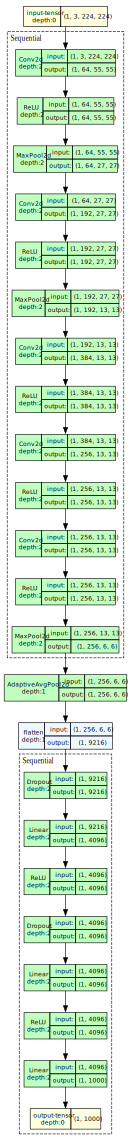

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import alexnet, AlexNet_Weights
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = alexnet(weights=None).to(device) 
# model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(device) 

print('model is on:', next(model.parameters()).device)

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True) # device='meta', 
model_graph.visual_graph

## CIFAR 10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

标准的alexnet输入224尺寸的图像，下面通过transforms.Resize缩放到目标尺寸

In [2]:
# Prepare CIFAR-10 dataset
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

dataset = CIFAR10("../data/", download=True, train=True, transform=preprocess)
dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

为了改善过拟合，此处切分训练集为训练集和验证集，通过验证集判定是否需要early stop。

In [3]:
from torch.utils.data import random_split

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [40000, 10000])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

In [4]:
import numpy as np
import torch
import os
from datetime import datetime

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_path, patience=5, verbose=False, delta=0):
        """
        Args:
            save_path : 模型保存文件夹
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.ts = datetime.today().strftime('%Y%m%d%H')
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = self.save_path + '_' + self.ts + '_best.pth'
        torch.save(model, path)	# 这里会存储迄今最优模型的参数

In [5]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam - 某种梯度下降算法，此处不展开; lr - learning rate
model.train()
#lambda_reg = 0.01

#loss_history = []
#acc_history = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

es = EarlyStopping('./alexnet_cifar10_es', patience = 8)

# Run the training loop
for epoch in range(0, 50):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    corrects = 0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
      
        # Get inputs
        inputs, targets = data # X & y
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        #l2_norm = sum(p.pow(2).sum() for p in model.parameters()) # CHECK bias
        #loss += lambda_reg * l2_norm
        
        # Perform backward pass
        loss.backward() # 后向传播，计算所有参数的偏导数
        
        # Perform optimization
        optimizer.step() # 根据偏导数更新各个参数

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == targets.data)
        
        # Print statistics
        current_loss += loss.item()

    train_losses.append(current_loss)
    acc = corrects.double().item() / len(train_set)
    print('train acc =', acc)
    train_accs.append(acc)

    ######################## Evaluation on the val set ###################
    val_loss = 0
    val_corrects=0
    
    model.eval()  # 将模型改为预测模式

    for i, data in enumerate(val_loader, 0):
      
        # Get inputs
        inputs, targets = data # X & y
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        loss = loss_function(outputs, targets)

        # 记录误差
        val_loss += loss.item()

        # 记录准确率
        _, preds = torch.max(outputs, 1)
        val_corrects += torch.sum(preds == targets.data)

    val_losses.append(val_loss)
    val_acc = val_corrects.double().item() / len(val_set)
    val_accs.append(val_acc)
    print('validation acc =', val_acc)

    ##################### early stop ####################
    es(val_loss, model) # __call__
    #达到早停止条件时，early_stop会被置为True
    if es.early_stop:
        print("Early stopping")
        break #跳出迭代，结束训练

# Process is complete.
print('Training process has finished.')

Starting epoch 1
train acc = 0.31575
validation acc = 0.4213
Starting epoch 2
train acc = 0.458025
validation acc = 0.4605
Starting epoch 3
train acc = 0.522525
validation acc = 0.5242
Starting epoch 4
train acc = 0.572075
validation acc = 0.5545
Starting epoch 5
train acc = 0.614275
validation acc = 0.5628
EarlyStopping counter: 1 out of 8
Starting epoch 6
train acc = 0.65235
validation acc = 0.5068
EarlyStopping counter: 2 out of 8
Starting epoch 7
train acc = 0.6925
validation acc = 0.5879
Starting epoch 8
train acc = 0.743425
validation acc = 0.5738
EarlyStopping counter: 1 out of 8
Starting epoch 9
train acc = 0.78905
validation acc = 0.5759
EarlyStopping counter: 2 out of 8
Starting epoch 10
train acc = 0.828025
validation acc = 0.5814
EarlyStopping counter: 3 out of 8
Starting epoch 11
train acc = 0.85115
validation acc = 0.5668
EarlyStopping counter: 4 out of 8
Starting epoch 12
train acc = 0.876425
validation acc = 0.5836
EarlyStopping counter: 5 out of 8
Starting epoch 13
tra

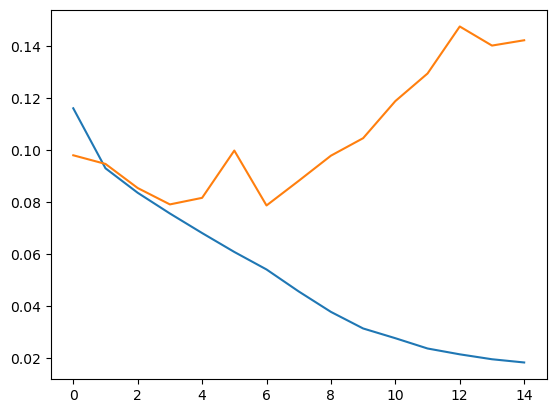

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.array(train_losses)/len(train_set))
plt.plot(np.array(val_losses)/len(val_set))

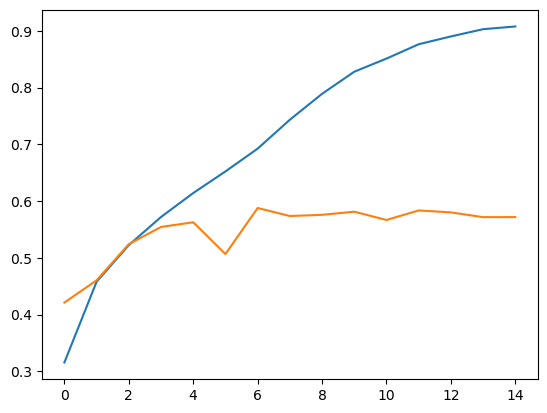

In [7]:
plt.plot(train_accs)
plt.plot(val_accs)

In [8]:
test_set = CIFAR10("../data/", train=False, download=True, transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=1)
test_set

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [9]:
import matplotlib.pyplot as plt

def evaluate_rgb_images(model, dataloader, max_samples = 100):

    model.eval()    
    sample_cnt = 0
    correct = 0
    for inputs, labels in dataloader:
    
        if sample_cnt >= max_samples:
            break
        sample_cnt += len(labels)
        
        plt.figure(figsize=(10,len(inputs)/10+1))
        for idx, img  in enumerate(inputs):
            plt.subplot(int(len(inputs)/10)+1, 10, idx+1)       
            # x = img * STD[:, None, None] + MEAN[:, None, None]
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.axis('off')
        plt.show()
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        print('truth: \n', labels)
        print('prediction: \n', preds)
        correct += (preds == labels).float().sum()
        
    accuracy = 100 * correct / sample_cnt
    print('classification accuracy (%) =', accuracy.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

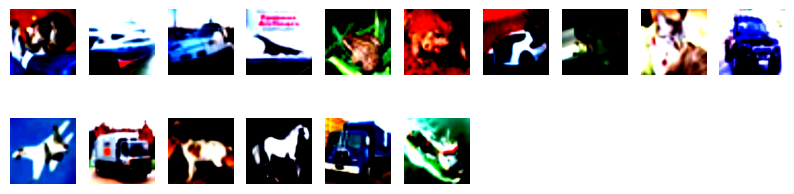

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8], device='cuda:0')
prediction: 
 tensor([5, 1, 8, 0, 6, 6, 4, 4, 3, 1, 0, 9, 4, 7, 9, 9], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


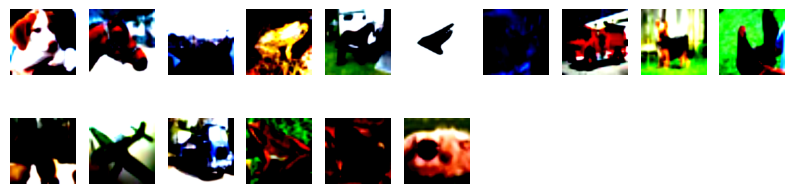

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truth: 
 tensor([5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5], device='cuda:0')
prediction: 
 tensor([5, 2, 8, 6, 7, 2, 2, 9, 4, 2, 7, 0, 9, 6, 6, 0], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


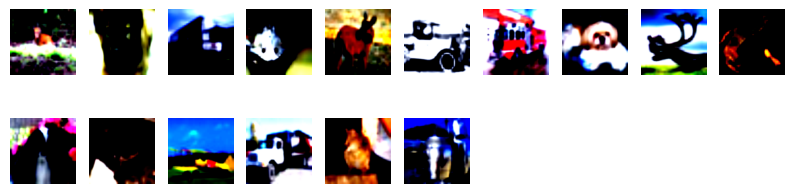

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9], device='cuda:0')
prediction: 
 tensor([8, 5, 9, 5, 7, 9, 9, 5, 4, 6, 7, 3, 0, 9, 3, 9], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


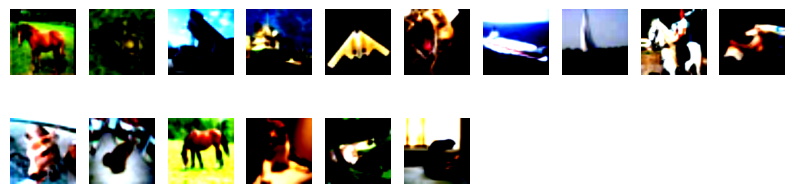

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3], device='cuda:0')
prediction: 
 tensor([7, 6, 9, 9, 6, 3, 8, 8, 7, 3, 7, 3, 7, 3, 6, 9], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


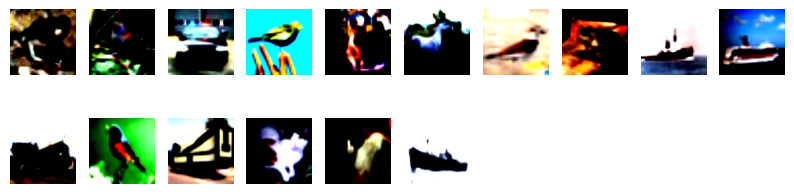

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8], device='cuda:0')
prediction: 
 tensor([6, 4, 1, 0, 3, 9, 4, 3, 8, 8, 9, 2, 0, 5, 3, 8], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


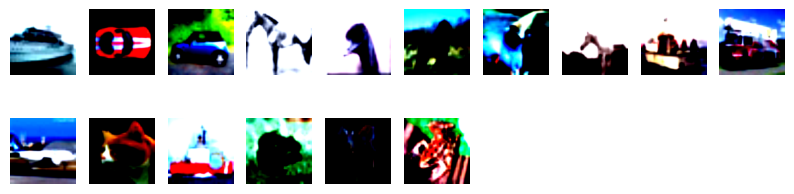

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truth: 
 tensor([8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6], device='cuda:0')
prediction: 
 tensor([8, 8, 1, 7, 2, 7, 8, 2, 3, 9, 0, 6, 8, 6, 4, 6], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


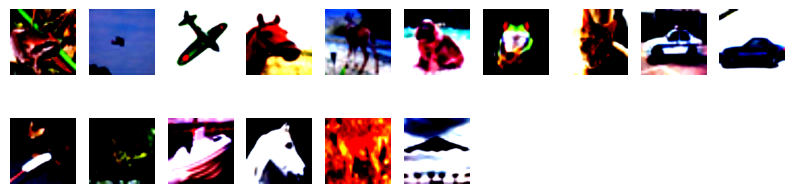

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0], device='cuda:0')
prediction: 
 tensor([6, 8, 0, 7, 7, 3, 6, 3, 1, 1, 3, 6, 3, 7, 4, 0], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


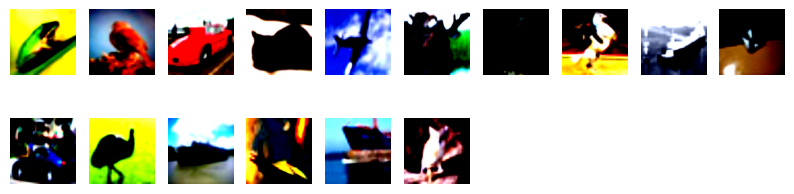

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
prediction: 
 tensor([2, 2, 9, 4, 0, 3, 2, 2, 8, 4, 1, 2, 8, 6, 3, 3], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


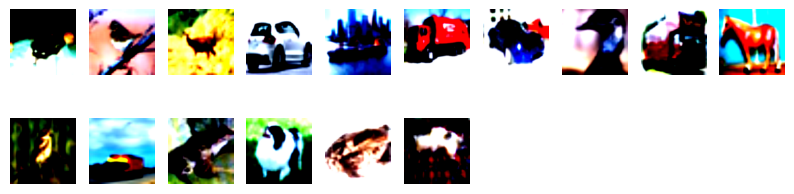

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3], device='cuda:0')
prediction: 
 tensor([3, 6, 4, 1, 8, 9, 3, 2, 9, 7, 4, 8, 6, 5, 3, 5], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


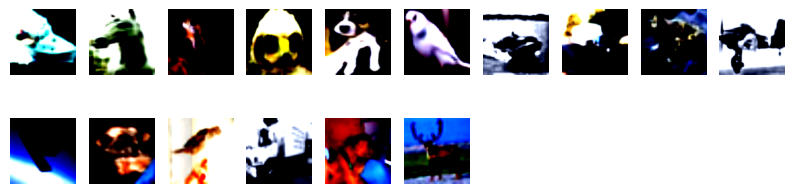

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4], device='cuda:0')
prediction: 
 tensor([8, 7, 3, 6, 7, 2, 0, 1, 9, 0, 0, 5, 2, 9, 5, 4], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


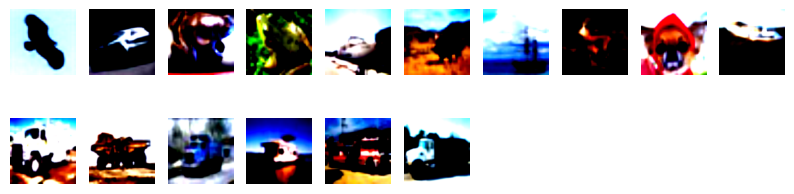

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

truth: 
 tensor([2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9], device='cuda:0')
prediction: 
 tensor([0, 1, 3, 3, 0, 7, 8, 2, 5, 9, 9, 3, 9, 8, 9, 9], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


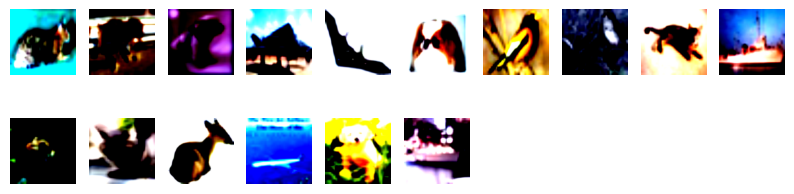

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truth: 
 tensor([3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8], device='cuda:0')
prediction: 
 tensor([3, 4, 7, 7, 0, 4, 6, 3, 7, 8, 6, 3, 3, 8, 5, 6], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

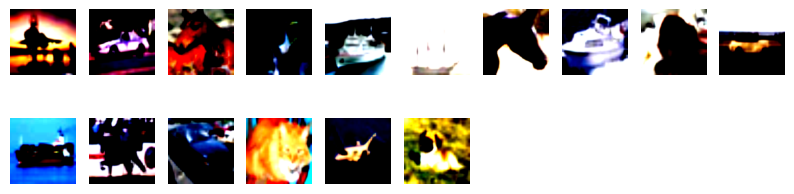

truth: 
 tensor([0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5], device='cuda:0')
prediction: 
 tensor([3, 7, 7, 3, 8, 8, 3, 8, 3, 0, 1, 7, 1, 3, 8, 5], device='cuda:0')
classification accuracy (%) = 57.21154022216797


In [10]:
evaluate_rgb_images(model, test_loader, max_samples = 200)

AlexNet from scratch训练测试准确率50%+；使用预训练权重，做finetuning准确率反而更低，说明cifar和imagenet两类数据集差异较大，无法从transfer learning（第四章将详细介绍）获益